In [96]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

import scipy

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
train_df = pd.read_csv('../../Desktop/howpop_train.csv')
test_df = pd.read_csv('../../Desktop/howpop_test.csv')

In [3]:
train_df.head(1).T

,0
url,https://habrahabr.ru/post/18284/
domain,habrahabr.ru
post_id,18284
published,2008-01-01 18:19:00
author,@Tapac
flow,develop
polling,False
content_len,4305
title,Новогодний подарок блоггерам — WordPress 2.3.2
comments,0


In [4]:
train_df.shape, test_df.shape

((134137, 17), (3990, 9))

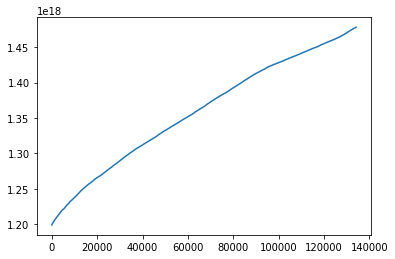

In [5]:
train_df['published'].apply(lambda ts: pd.to_datetime(ts).value).plot();

# Вопрос 1. Есть ли в train_df признаки, корреляция между которыми больше 0.9? Обратите внимание, именно различные признаки - корреляция признака с самим собой естественно больше 0.9 :)
* нет

In [6]:
train_df.corr() > 0.9

,post_id,polling,content_len,comments,favs,views,votes_plus,votes_minus,views_lognorm,favs_lognorm,comments_lognorm
post_id,True,False,False,False,False,False,False,False,False,False,False
polling,False,True,False,False,False,False,False,False,False,False,False
content_len,False,False,True,False,False,False,False,False,False,False,False
comments,False,False,False,True,False,False,False,False,False,False,False
favs,False,False,False,False,True,False,False,False,False,False,False
views,False,False,False,False,False,True,False,False,False,False,False
votes_plus,False,False,False,False,False,False,True,False,False,False,False
votes_minus,False,False,False,False,False,False,False,True,False,False,False
views_lognorm,False,False,False,False,False,False,False,False,True,False,False
favs_lognorm,False,False,False,False,False,False,False,False,False,True,False


## Вопрос 2. В каком году было больше всего публикаций? (Рассматриваем train_df)
* 2015

In [27]:
train_df['published'] = pd.to_datetime(train_df['published'], errors='coerce')

In [32]:
year = train_df['published'].dt.year

In [36]:
year.value_counts()

2015    23452
2016    16316
2014    16180
2012    15972
2013    15537
2011    15063
2010    13091
2009    10783
2008     7743
Name: published, dtype: int64

## Разбиение на train/valid
### Используем только признаки 'author', 'flow', 'domain' и 'title

In [37]:
features = ['author', 'flow', 'domain','title']
train_size = int(0.7 * train_df.shape[0])

In [38]:
len(train_df), train_size

(134137, 93895)

In [39]:
X, y = train_df.loc[:, features],  train_df['favs_lognorm'] #отделяем признаки от целевой переменной

X_test = test_df.loc[:, features]

In [40]:
X_train, X_valid = X.iloc[:train_size, :], X.iloc[train_size:,:]

y_train, y_valid = y.iloc[:train_size], y.iloc[train_size:]

In [50]:
vectorizer_title = TfidfVectorizer(min_df=3, max_df=0.3, ngram_range=(1,3))

## Вопрос 3. Какой размер у полученного словаря?
* 50624

In [51]:
tf.fit_transform(X_train['title'])

<93895x50624 sparse matrix of type '<class 'numpy.float64'>'
	with 676626 stored elements in Compressed Sparse Row format>

In [52]:
tf.transform(X_valid['title'])

<40242x50624 sparse matrix of type '<class 'numpy.float64'>'
	with 295950 stored elements in Compressed Sparse Row format>

In [53]:
tf.transform(X_test['title'])

<3990x50624 sparse matrix of type '<class 'numpy.float64'>'
	with 28584 stored elements in Compressed Sparse Row format>

In [58]:
vectorizer_title = TfidfVectorizer(min_df=3, max_df=0.3, ngram_range=(1,3))

X_train_title = vectorizer_title.fit_transform(X_train['title'])
X_valid_title = vectorizer_title.transform(X_valid['title'])
X_test_title = vectorizer_title.transform(X_test['title'])

In [73]:
vectorizer_title.vocabulary_

{'новогодний': 31497,
 'подарок': 36257,
 'блоггерам': 14241,
 'wordpress': 12172,
 'новогодний подарок': 31499,
 'сумасшедшие': 45476,
 'яйца': 50489,
 'или': 22661,
 'сервис': 42745,
 'для': 18811,
 'отслеживания': 34225,
 'посетителей': 37373,
 'или сервис': 22833,
 'сервис для': 42751,
 'для отслеживания': 19413,
 'или сервис для': 22834,
 'сервис для отслеживания': 42753,
 'сглаживание': 42460,
 'шрифтов': 49862,
 'отрисовка': 34214,
 'сглаживание шрифтов': 42461,
 'почему': 37632,
 'мне': 28231,
 'не': 30755,
 'нравится': 31925,
 'iphone': 5951,
 'почему мне': 37659,
 'мне не': 28233,
 'не нравится': 30851,
 'всеобщая': 16456,
 'доступность': 20285,
 'действии': 18272,
 'чем': 49165,
 'суть': 45504,
 'проекта': 39310,
 'ru': 9541,
 'search': 9842,
 'запускается': 21584,
 'понедельник': 37201,
 'mobile': 7315,
 'выбор': 16759,
 'способа': 44575,
 'связи': 42437,
 'обзор': 32095,
 'под': 36147,
 'windows': 11973,
 'под windows': 36185,
 'онлайн': 33063,
 'банкинг': 13661,
 'оформле

## Вопрос 4. Какой индекс у слова 'python'?
* 9065

In [78]:
vectorizer_title.vocabulary_.get('python')

9065

## Инициализируйте TfidfVectorizer, указав analyzer='char'.
## Примените метод fit_transform к X_train['title'] и метод transform к X_valid['title'] и X_test['title']

In [79]:
vectorizer_title_ch = TfidfVectorizer(analyzer='char')

X_train_title_ch = vectorizer_title_ch.fit_transform(X_train['title'])
X_valid_title_ch = vectorizer_title_ch.transform(X_valid['title'])
X_test_title_ch = vectorizer_title_ch.transform(X_test['title'])

In [80]:
vectorizer_title_ch.vocabulary_

{'н': 133,
 'о': 134,
 'в': 122,
 'г': 123,
 'д': 124,
 'и': 128,
 'й': 129,
 ' ': 0,
 'п': 135,
 'а': 120,
 'р': 136,
 'к': 130,
 'б': 121,
 'л': 131,
 'е': 125,
 'м': 132,
 '—': 170,
 'w': 61,
 'o': 53,
 'r': 56,
 'd': 42,
 'p': 54,
 'e': 43,
 's': 57,
 '2': 18,
 '.': 14,
 '3': 19,
 'с': 137,
 'у': 139,
 'ш': 144,
 'я': 151,
 'ц': 142,
 ',': 12,
 'т': 138,
 'ж': 126,
 'ф': 140,
 'ь': 148,
 'ч': 143,
 'i': 47,
 'h': 46,
 'n': 52,
 'm': 51,
 'b': 40,
 'l': 50,
 '0': 16,
 'щ': 145,
 'k': 49,
 'v': 60,
 'a': 39,
 'u': 59,
 ':': 26,
 'c': 41,
 'з': 127,
 'ы': 147,
 '«': 76,
 '»': 85,
 'х': 141,
 'j': 48,
 '?': 31,
 't': 58,
 '-': 13,
 '1': 17,
 '8': 24,
 '!': 1,
 '9': 25,
 '5': 21,
 '7': 23,
 'q': 55,
 'y': 63,
 'x': 62,
 'g': 45,
 'ю': 150,
 'ъ': 146,
 '4': 20,
 '=': 29,
 '(': 8,
 ')': 9,
 '+': 11,
 'f': 44,
 '…': 178,
 'э': 149,
 '6': 22,
 'z': 64,
 '/': 15,
 '$': 4,
 'ё': 152,
 "'": 7,
 '№': 187,
 '–': 169,
 '[': 33,
 ']': 35,
 '_': 37,
 '\xa0': 71,
 '*': 10,
 '%': 5,
 '{': 65,
 '}': 6

In [154]:
X_test_title_ch

<3990x218 sparse matrix of type '<class 'numpy.float64'>'
	with 98923 stored elements in Compressed Sparse Row format>

In [153]:
X_valid_title_ch

<40242x218 sparse matrix of type '<class 'numpy.float64'>'
	with 1004780 stored elements in Compressed Sparse Row format>

In [152]:
X_train_title_ch

<93895x218 sparse matrix of type '<class 'numpy.float64'>'
	with 2159346 stored elements in Compressed Sparse Row format>

In [81]:
vectorizer_title_wr = TfidfVectorizer(analyzer='word')

X_train_title_wr = vectorizer_title_wr.fit_transform(X_train['title'])
X_valid_title_wr = vectorizer_title_wr.transform(X_valid['title'])
X_test_title_wr = vectorizer_title_wr.transform(X_test['title'])

In [82]:
vectorizer_title_wr.vocabulary_

{'новогодний': 48759,
 'подарок': 54647,
 'блоггерам': 25553,
 'wordpress': 21381,
 'сумасшедшие': 68522,
 'яйца': 77430,
 'или': 37172,
 'сервис': 64531,
 'для': 33086,
 'отслеживания': 51937,
 'посетителей': 56507,
 'сглаживание': 64135,
 'шрифтов': 76243,
 'субпиксельная': 68439,
 'отрисовка': 51895,
 'почему': 56991,
 'мне': 45195,
 'не': 47395,
 'нравится': 48994,
 'iphone': 10063,
 'mobile2': 12587,
 'всеобщая': 28955,
 'доступность': 33705,
 'modbook': 12637,
 'действии': 32081,
 'чем': 75346,
 'суть': 68647,
 'проекта': 59184,
 'vladelia': 20675,
 'ru': 16695,
 'подтверждено': 55196,
 'wikia': 21200,
 'search': 17177,
 'запускается': 35706,
 'понедельник': 56124,
 'mobile': 12586,
 'выбор': 29208,
 'предпочтительного': 57500,
 'способа': 67222,
 'связи': 64094,
 'обзор': 49211,
 'лаунчеров': 42339,
 'под': 54613,
 'windows': 21250,
 'онлайн': 50431,
 'банкинг': 24515,
 'оформление': 52098,
 'рабочего': 60483,
 'места': 44465,
 'новые': 48804,
 'скриншоты': 65377,
 'cairo': 3835

## Работа с категориальными признаками
#### Для обработки категориальных признаков 'author', 'flow', 'domain' мы будем использовать DictVectorizer из sklearn.

In [83]:
feats = ['author', 'flow', 'domain']
X_train[feats][:5]

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,NaN,geektimes.ru


In [84]:
# сначала заполняем пропуски прочерком
X_train[feats][:5].fillna('-')

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,-,geektimes.ru


In [85]:
# Преобразуем датафрейм в словарь, где ключами являются индексы объектов (именно для этого мы транспонировали датафрейм),
# а значениями являются словари в виде 'название_колонки':'значение'
X_train[feats][:5].fillna('-').T.to_dict()

{0: {'author': '@Tapac', 'flow': 'develop', 'domain': 'habrahabr.ru'},
 1: {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'},
 2: {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'},
 3: {'author': '@Taoorus', 'flow': 'design', 'domain': 'habrahabr.ru'},
 4: {'author': '@dennydo', 'flow': '-', 'domain': 'geektimes.ru'}}

In [86]:
# В DictVectorizer нам нужно будет передать список словарей для каждого объекта в виде 'название_колонки':'значение',
# поэтому используем .values()
X_train[feats][:5].fillna('-').T.to_dict().values()

dict_values([{'author': '@Tapac', 'flow': 'develop', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@Taoorus', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@dennydo', 'flow': '-', 'domain': 'geektimes.ru'}])

In [87]:
# В итоге получается разреженная матрица
dict_vect = DictVectorizer()
dict_vect_matrix = dict_vect.fit_transform(X_train[feats][:5].fillna('-').T.to_dict().values())
dict_vect_matrix

<5x9 sparse matrix of type '<class 'numpy.float64'>'
	with 15 stored elements in Compressed Sparse Row format>

In [88]:
# Но можно преобразовать ее в numpy array с помощью .toarray()
dict_vect_matrix.toarray()

array([[0., 0., 1., 0., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 1., 0., 1., 0., 0.]])

In [89]:
# В получившейся матрице 5 строк (по числу объектов) и 9 столбцов
# Далее разберемся почему колонок именно 9
dict_vect_matrix.shape

(5, 9)

In [90]:
for col in feats:
    print(col,len(X_train[col][:5].fillna('-').unique()))

author 4
flow 3
domain 2


In [104]:
# например, самая первая колонка называется 'author=@DezmASter' - то есть принимает значение 1 только если автор @DezmASter
dict_vect.feature_names_

['author=@DezmASter',
 'author=@Taoorus',
 'author=@Tapac',
 'author=@dennydo',
 'domain=geektimes.ru',
 'domain=habrahabr.ru',
 'flow=-',
 'flow=design',
 'flow=develop']

## Инициализируйте DictVectorizer с параметрами по умолчанию.
## Примените метод fit_transform к X_train[feats] и метод transform к X_valid[feats] и X_test[feats]

In [115]:
vectorizer_feats = DictVectorizer()

X_train_feats = vectorizer_feats.fit_transform(X_train[feats].fillna('-').T.to_dict().values())
X_valid_feats = vectorizer_feats.transform(X_valid[feats].fillna('-').T.to_dict().values())
X_test_feats = vectorizer_feats.transform(X_test[feats].fillna('-').T.to_dict().values())

In [116]:
X_train_feats.shape

(93895, 17869)

##### Соединим все полученные матрицы при помощи scipy.sparse.hstack()

In [117]:
X_train_new = scipy.sparse.hstack([X_train_title, X_train_feats, X_train_title_ch])
X_valid_new = scipy.sparse.hstack([X_valid_title, X_valid_feats, X_valid_title_ch])
X_test_new =  scipy.sparse.hstack([X_test_title, X_test_feats, X_test_title_ch])

#### Обучите две модели на X_train_new, y_train, задав в первой alpha=0.1 и random_state = 1, а во второй alpha=1.0 и random_state = 1

#### Рассчитайте среднеквадратичную ошибку каждой модели (mean_squared_error). Сравните значения ошибки на обучающей и тестовой выборках и ответьте на вопросы.

In [130]:
%%time
model1 = Ridge(alpha=0.1, random_state=1)
model1.fit(X_train_new, y_train)

Wall time: 3.41 s


Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=1, solver='auto', tol=0.001)

In [131]:
train_preds1 = model1.predict(X_train_new)
valid_preds1 = model1.predict(X_valid_new)

print('Ошибка на трейне',mean_squared_error(y_train, train_preds1))
print('Ошибка на тесте',mean_squared_error(y_valid, valid_preds1))

Ошибка на трейне 0.18474381545724863
Ошибка на тесте 0.9023933286685926


In [129]:
%%time
model2 = Ridge(alpha=1.0, random_state=1)
model2.fit(X_train_new, y_train)

Wall time: 1.75 s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=1, solver='auto', tol=0.001)

In [132]:
train_preds2 = model2.predict(X_train_new)
valid_preds2 = model2.predict(X_valid_new)

print('Ошибка на трейне',mean_squared_error(y_train, train_preds2))
print('Ошибка на тесте',mean_squared_error(y_valid, valid_preds2))

Ошибка на трейне 0.2866188771731544
Ошибка на тесте 0.7006604033990846


## Вопрос 6. Выберите верные утверждения:

* при alpha=1.0 у модели обощающая способность лучше, чем у при alpha=0.1
* при alpha=0.1 модель переобучается


# Baseline
### Теперь попытаемся получить бейзлайн для соревования - используйте Ridge с параметрами по умолчанию и обучите модель на всех данных - соедините X_train_new X_valid_new (используйте scipy.sparse.vstack()), а целевой переменной будет y.

In [144]:
%%time
model = Ridge()

X_train_valid = scipy.sparse.vstack([X_train_new, X_valid_new])

model.fit(X_train_valid, y)

test_preds = model.predict(X_test_new)

Wall time: 2.99 s


In [147]:
sample_submission = pd.read_csv('../../Desktop/sample_submission.csv', 
                                index_col='url')

In [148]:
sample_submission.head()

,favs_lognorm
url,
https://habrahabr.ru/post/314080/,0.323588
https://habrahabr.ru/company/plesk/blog/313732/,0.560105
https://habrahabr.ru/company/etagi/blog/314000/,0.667039
https://habrahabr.ru/company/knopka/blog/314030/,0.149563
https://geektimes.ru/company/audiomania/blog/282058/,0.670754


In [149]:
ridge_submission = sample_submission.copy()
ridge_submission['favs_lognorm'] = test_preds
# это будет бейзлайн "Простое решение"
ridge_submission.to_csv('ridge_baseline.csv') 